### Notebook for the label transfer of healthy skin to infected skin using `scANVI`

- **Developed by:** Carlos Talavera-López Ph.D
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- v230704

### Import required modules

In [1]:
import scvi
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

/Users/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/Users/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/cartalop/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is depreca

### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                 9.4.0
absl                NA
aiohttp             3.8.4
aiosignal           1.3.1
anyio               NA
appnope             0.1.3
asttokens           NA
async_timeout       4.0.2
attr                23.1.0
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
brotli              NA
bs4                 4.12.2
certifi             2022.12.07
cffi                1.15.1
charset_normalizer  2.1.1
chex                0.1.6
click               8.1.3
colorama            0.4.6
contextlib2         NA
croniter            NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.6
decorator           5.1.1
deepdiff            6.3.0
docrep              0.3.2
executing           1.2.0
fastapi             0.99.1
flax                0.5.0
frozenlist          1.3.3
fsspec              2023.3.0
h5py                3.8.0
hypergeom_ufunc     NA
idna                3.4
igraph   

In [3]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

Global seed set to 1712


In [4]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

### Read in Healthy data

In [5]:
SCC0120_1_Skin = sc.read_h5ad('../data/SCC0120_1_Skin_scANVI_annot_ctl230702.h5ad')
SCC0120_1_Skin

AnnData object with n_obs × n_vars = 7479 × 27449
    obs: 'sample_id', 'Status', 'Site', 'Tissue', 'Location', 'donor_id', 'Sex', 'full_clustering', 'seed_labels', 'donor', 'cell_states', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_CITE', 'nFeature_CITE', 'nCount_PROT', 'nFeature_PROT', 'percent.mt', 'sample', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'tissue', 'condition', 'n_genes', 'doublet_scores', 'hashtag', 'unique', 'group', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-SCC0120_1_skin', 'feature_types-SCC0120_1_skin', 'mt-SCC0120_1_skin', 'ribo-SCC0120_1_skin', 'n_cells_by_counts-SCC0120_1_skin', 'mean_counts-SCC0120_1_skin', 'pct_dropout_by_counts-SCC0120_1_skin', 'total_counts

In [6]:
SCC0120_1_Skin.obs['condition'].cat.categories

Index(['healthy', 'infected'], dtype='object')

In [7]:
SCC0120_1_HS = SCC0120_1_Skin[SCC0120_1_Skin.obs['condition'].isin(['healthy'])]
SCC0120_1_HS

View of AnnData object with n_obs × n_vars = 3532 × 27449
    obs: 'sample_id', 'Status', 'Site', 'Tissue', 'Location', 'donor_id', 'Sex', 'full_clustering', 'seed_labels', 'donor', 'cell_states', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_CITE', 'nFeature_CITE', 'nCount_PROT', 'nFeature_PROT', 'percent.mt', 'sample', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'tissue', 'condition', 'n_genes', 'doublet_scores', 'hashtag', 'unique', 'group', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-SCC0120_1_skin', 'feature_types-SCC0120_1_skin', 'mt-SCC0120_1_skin', 'ribo-SCC0120_1_skin', 'n_cells_by_counts-SCC0120_1_skin', 'mean_counts-SCC0120_1_skin', 'pct_dropout_by_counts-SCC0120_1_skin', 'tota

In [8]:
SCC0120_1_IS = SCC0120_1_Skin[SCC0120_1_Skin.obs['condition'].isin(['infected'])]
SCC0120_1_IS

View of AnnData object with n_obs × n_vars = 3947 × 27449
    obs: 'sample_id', 'Status', 'Site', 'Tissue', 'Location', 'donor_id', 'Sex', 'full_clustering', 'seed_labels', 'donor', 'cell_states', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_CITE', 'nFeature_CITE', 'nCount_PROT', 'nFeature_PROT', 'percent.mt', 'sample', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'tissue', 'condition', 'n_genes', 'doublet_scores', 'hashtag', 'unique', 'group', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-SCC0120_1_skin', 'feature_types-SCC0120_1_skin', 'mt-SCC0120_1_skin', 'ribo-SCC0120_1_skin', 'n_cells_by_counts-SCC0120_1_skin', 'mean_counts-SCC0120_1_skin', 'pct_dropout_by_counts-SCC0120_1_skin', 'tota

In [9]:
SCC0120_1_HS.obs['seed_labels'] = SCC0120_1_HS.obs['C_scANVI'].copy()
SCC0120_1_IS.obs['seed_labels'] = 'Unknown'

In [10]:
adata = SCC0120_1_HS.concatenate(SCC0120_1_IS, batch_key = 'skin_condition', batch_categories = ['healthy', 'infected'], join = 'inner')
adata

AnnData object with n_obs × n_vars = 7479 × 27449
    obs: 'sample_id', 'Status', 'Site', 'Tissue', 'Location', 'donor_id', 'Sex', 'full_clustering', 'seed_labels', 'donor', 'cell_states', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_CITE', 'nFeature_CITE', 'nCount_PROT', 'nFeature_PROT', 'percent.mt', 'sample', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'tissue', 'condition', 'n_genes', 'doublet_scores', 'hashtag', 'unique', 'group', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'skin_condition'
    var: 'gene_ids-SCC0120_1_skin', 'feature_types-SCC0120_1_skin', 'mt-SCC0120_1_skin', 'ribo-SCC0120_1_skin', 'n_cells_by_counts-SCC0120_1_skin', 'mean_counts-SCC0120_1_skin', 'pct_dropout_by_counts-SCC0120_1_sk

In [11]:
adata.obs['seed_labels'].value_counts()

Unknown                3947
Pericyte_1             1350
Tc                      502
Th                      427
F1                      317
VE1                     218
VE2                     177
F2                      135
Melanocyte              100
Treg                     86
Mono_mac                 61
moDC                     49
LE2                      41
Macro_1                  37
Undifferentiated_KC      16
Differentiated_KC        15
migLC                     1
Name: seed_labels, dtype: int64

### Select HVGs

In [12]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "donor",
    subset = True
)

adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 7479 × 7000
    obs: 'sample_id', 'Status', 'Site', 'Tissue', 'Location', 'donor_id', 'Sex', 'full_clustering', 'seed_labels', 'donor', 'cell_states', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_CITE', 'nFeature_CITE', 'nCount_PROT', 'nFeature_PROT', 'percent.mt', 'sample', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'tissue', 'condition', 'n_genes', 'doublet_scores', 'hashtag', 'unique', 'group', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'skin_condition'
    var: 'gene_ids-SCC0120_1_skin', 'feature_types-SCC0120_1_skin', 'mt-SCC0120_1_skin', 'ribo-SCC0120_1_skin', 'n_cells_by_counts-SCC0120_1_skin', 'mean_counts-SCC0120_1_skin', 'pct_dropout_by_counts-SCC0120_1_ski

### Transfer of annotation with scANVI

In [13]:
scvi.model.SCVI.setup_anndata(adata,
                        batch_key = 'donor',
                        labels_key = 'seed_labels',
                        categorical_covariate_keys = ['donor', 'batch'],                    
                        continuous_covariate_keys = ['n_genes', 'n_counts'], 
                        layer = 'counts')

In [14]:
scvi_model = scvi.model.SCVI(adata, 
                             n_latent = 50, 
                             n_layers = 3,
                             dispersion = 'gene-batch',
                             gene_likelihood = 'nb')

In [15]:
scvi_model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [30:23<00:00,  4.16s/it, v_num=1, train_loss_step=2.86e+3, train_loss_epoch=2.83e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [30:23<00:00,  4.56s/it, v_num=1, train_loss_step=2.86e+3, train_loss_epoch=2.83e+3]


### Label transfer with `scANVI` 

In [16]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [17]:
scanvi_model.train()

INFO     Training for 10 epochs.                                                                                   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 10/10: 100%|██████████| 10/10 [00:55<00:00,  5.74s/it, v_num=1, train_loss_step=2.97e+3, train_loss_epoch=2.92e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:55<00:00,  5.58s/it, v_num=1, train_loss_step=2.97e+3, train_loss_epoch=2.92e+3]


In [18]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [19]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

- Visualise corrected dataset

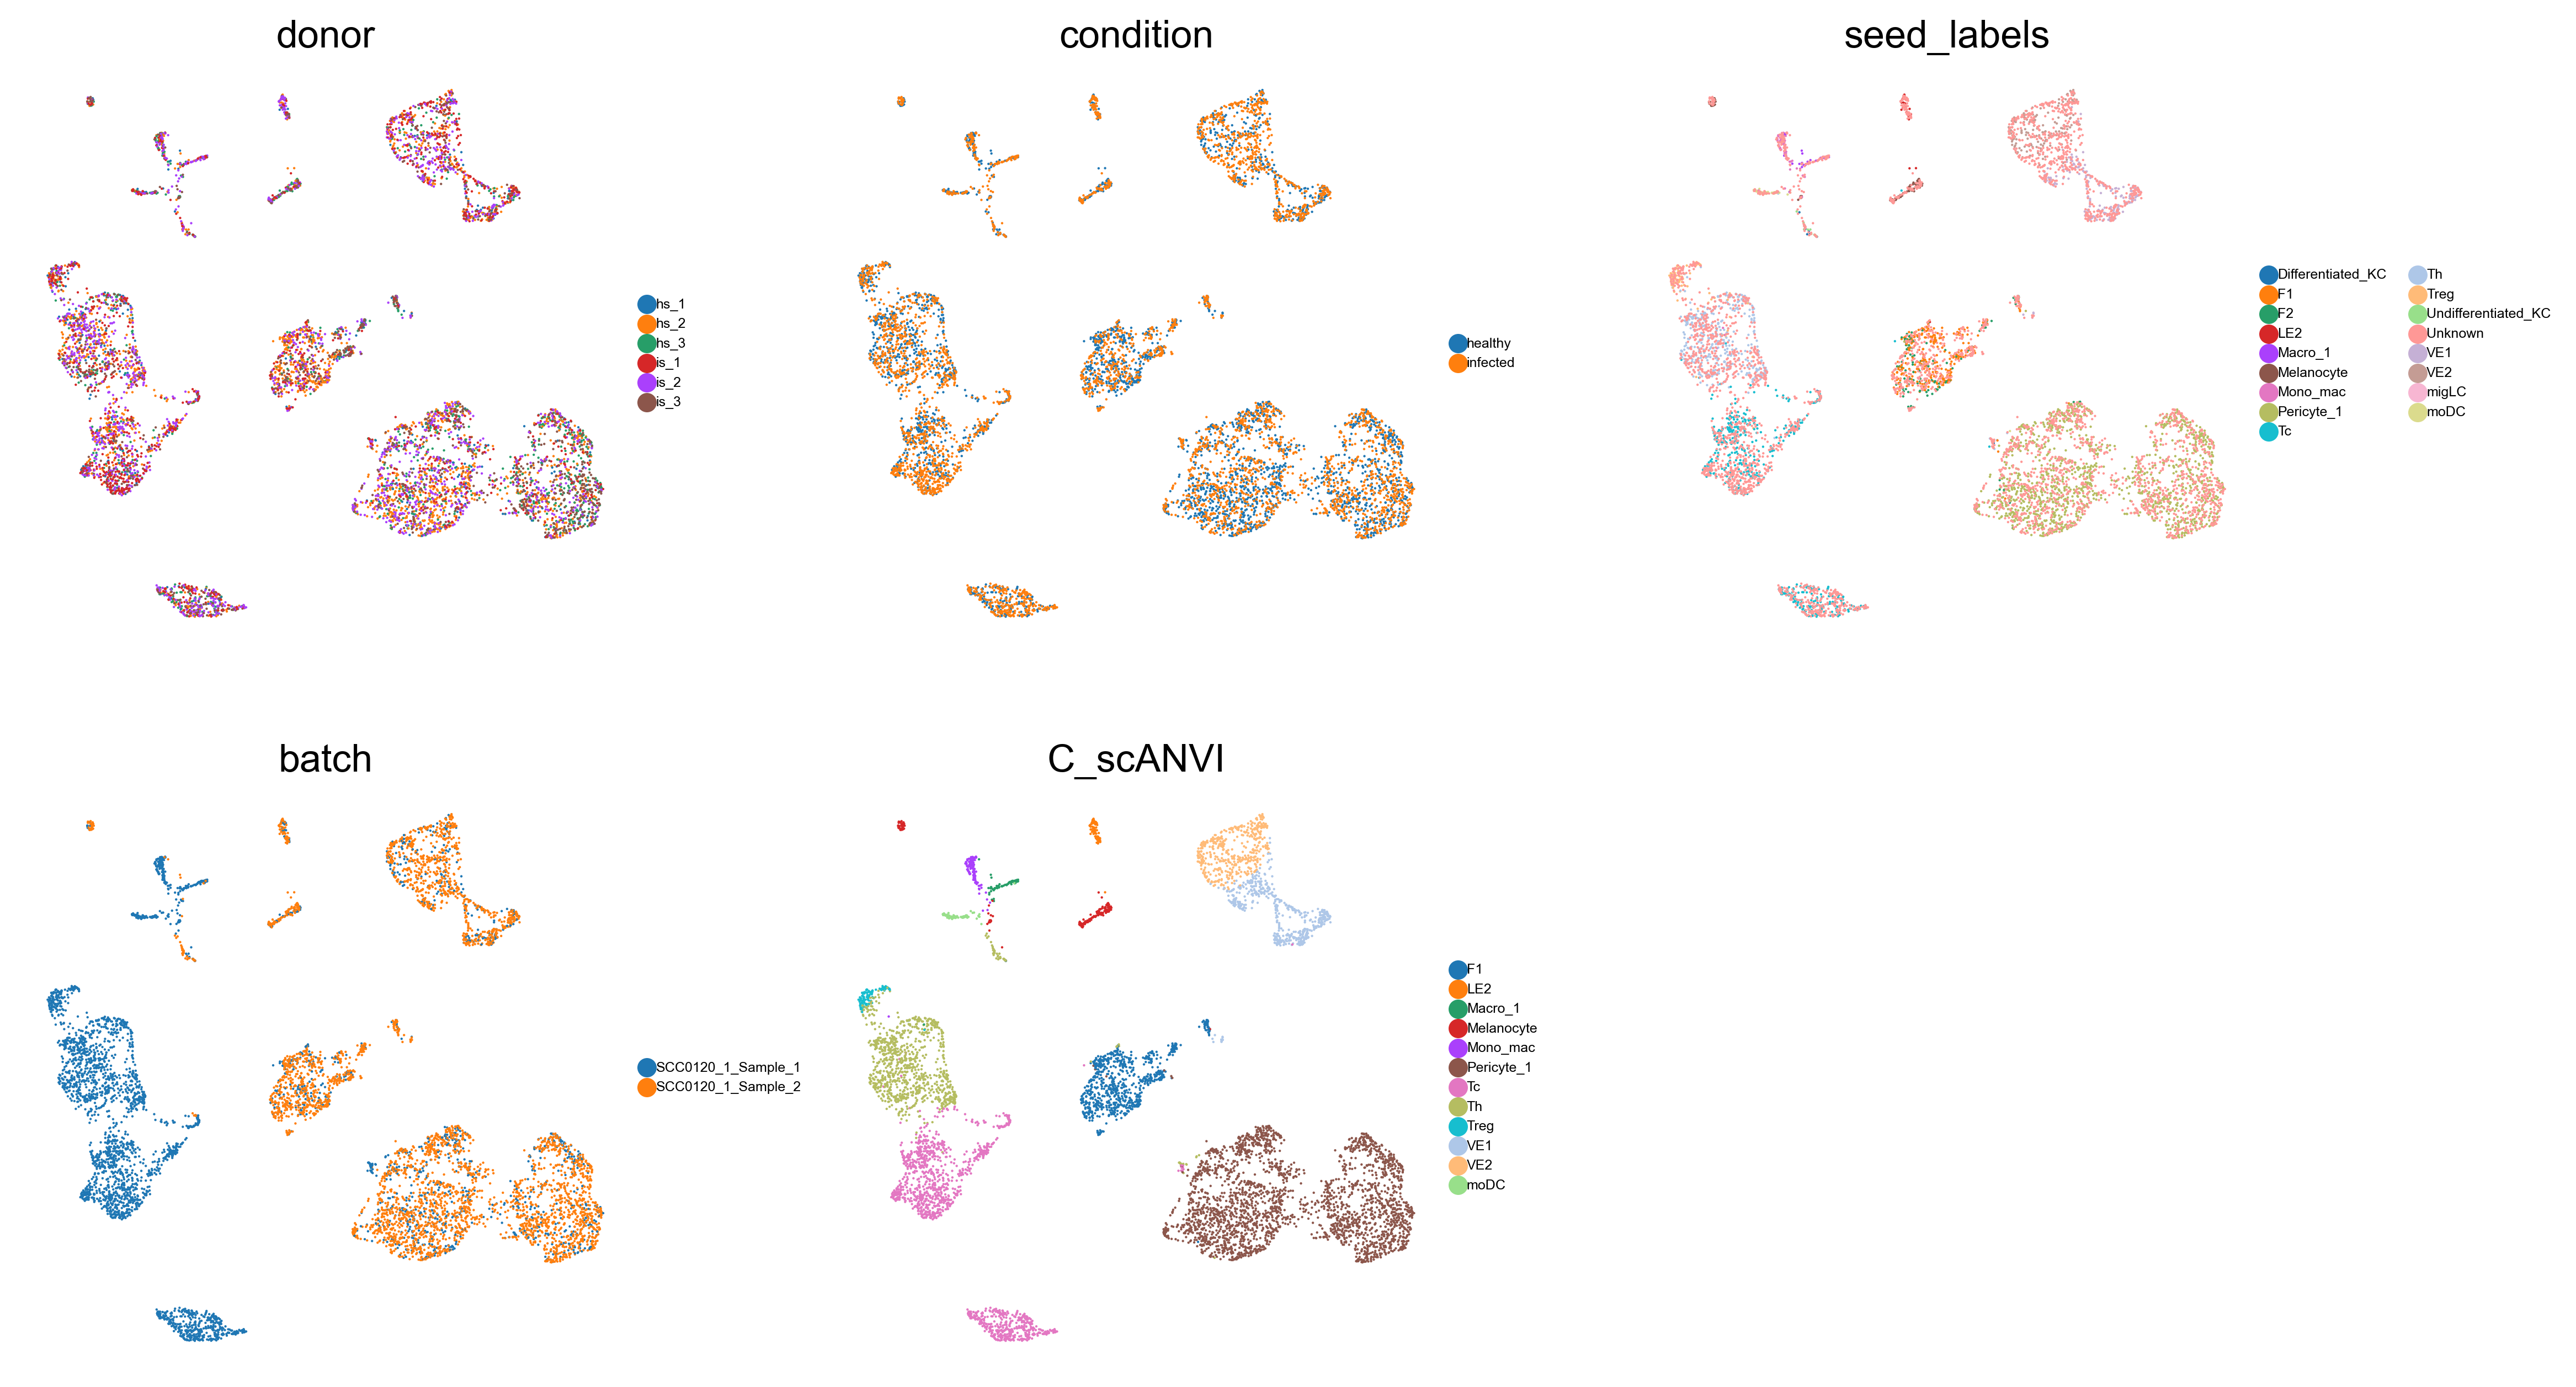

In [27]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)
sc.pl.umap(adata, frameon = False, color = ['donor', 'condition', 'seed_labels', 'batch', 'C_scANVI'], size = 3, legend_fontsize = 5, ncols = 3)

### Export annotated object

In [21]:
adata_skin = anndata.AnnData(X = adata_raw.X, var = adata_raw.var, obs = adata.obs, obsm = adata.obsm) 
adata_skin

AnnData object with n_obs × n_vars = 7479 × 27449
    obs: 'sample_id', 'Status', 'Site', 'Tissue', 'Location', 'donor_id', 'Sex', 'full_clustering', 'seed_labels', 'donor', 'cell_states', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_CITE', 'nFeature_CITE', 'nCount_PROT', 'nFeature_PROT', 'percent.mt', 'sample', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'tissue', 'condition', 'n_genes', 'doublet_scores', 'hashtag', 'unique', 'group', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'skin_condition'
    var: 'gene_ids-SCC0120_1_skin', 'feature_types-SCC0120_1_skin', 'mt-SCC0120_1_skin', 'ribo-SCC0120_1_skin', 'n_cells_by_counts-SCC0120_1_skin', 'mean_counts-SCC0120_1_skin', 'pct_dropout_by_counts-SCC0120_1_sk

In [22]:
SCC0120_1_skin_annotated = adata_skin[adata_skin.obs['group'].isin(['SCC0120_1_skin'])]
SCC0120_1_skin_annotated

View of AnnData object with n_obs × n_vars = 7479 × 27449
    obs: 'sample_id', 'Status', 'Site', 'Tissue', 'Location', 'donor_id', 'Sex', 'full_clustering', 'seed_labels', 'donor', 'cell_states', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_CITE', 'nFeature_CITE', 'nCount_PROT', 'nFeature_PROT', 'percent.mt', 'sample', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'tissue', 'condition', 'n_genes', 'doublet_scores', 'hashtag', 'unique', 'group', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'skin_condition'
    var: 'gene_ids-SCC0120_1_skin', 'feature_types-SCC0120_1_skin', 'mt-SCC0120_1_skin', 'ribo-SCC0120_1_skin', 'n_cells_by_counts-SCC0120_1_skin', 'mean_counts-SCC0120_1_skin', 'pct_dropout_by_counts-SCC0

In [28]:
SCC0120_1_skin_annotated.write('../data/SCC0120_1_Skin_scANVI_states_ctl230706.h5ad')